In [2]:
import pandas as pd
import lzma

df_reddit = pd.read_csv(
    lzma.open("../data/reddit_opinion_PSE_ISR.csv.lzma"), low_memory=False)

df_acled = pd.read_csv("../data/acled_middle_east_data.csv")

/var/folders/8s/5kb_fl851lbfqsvhg3z5m8ww0000gn/T/ipykernel_47836/1915750956.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
df_reddit.columns

Index(['comment_id', 'score', 'self_text', 'subreddit', 'created_time',
       'post_id', 'author_name', 'controversiality', 'ups', 'downs',
       'user_is_verified', 'user_account_created_time', 'user_awardee_karma',
       'user_awarder_karma', 'user_link_karma', 'user_comment_karma',
       'user_total_karma', 'post_score', 'post_self_text', 'post_title',
       'post_upvote_ratio', 'post_thumbs_ups', 'post_total_awards_received',
       'post_created_time'],
      dtype='object')

In [55]:
df_reddit['created_time'].min()

Timestamp('2023-09-02 00:00:00')

- do sentiment analysis --> percent positive / negative in last 7 days
- things to evaluate over 7 days


In [15]:
import pandas as pd
from datetime import timedelta
import math

# DON"T RUN THE REST OF THIS UNLESS YOU WANT TO CHANGE PREV_DAYS AND CREATE THE DATASET ALL OVER

PREV_DAYS = 5

seven_days_avg_df = pd.DataFrame()

df_reddit['user_account_created_time'] = pd.to_datetime(
    df_reddit['user_account_created_time']).dt.normalize()

df_acled['event_date'] = pd.to_datetime(
    df_acled['event_date']).dt.normalize()

df_reddit['created_time'] = pd.to_datetime(
    df_reddit['created_time']).dt.normalize()

# periods_between = math.ceil((df_reddit['created_time'].max() -
#                              df_reddit['created_time'].min()).days/PREV_DAYS)

dyas_between = (df_reddit['created_time'].max() -
                df_reddit['created_time'].min()).days

times = [df_reddit['created_time'].min() + timedelta(days=i)
         for i in range(5, dyas_between+6)]

df_reddit.dropna(subset=['created_time', 'controversiality', "user_is_verified",
                 "user_total_karma", "post_total_awards_received"], inplace=True)

for time in times:
    events_count = df_acled.loc[df_acled["event_date"]
                                < time]["event_date"].count()
    filtered_reddit = df_reddit.loc[df_reddit["created_time"] < time]

    total_posts = filtered_reddit.shape[0]
    if total_posts > 0:
        percentage_controversial_posts = filtered_reddit['controversiality'].sum(
        ) / total_posts * 100
        percentage_verified_users = filtered_reddit['user_is_verified'].sum(
        ) / total_posts * 100
        avg_user_total_karma = filtered_reddit["user_total_karma"].mean()
        avg_post_score = filtered_reddit["score"].mean()
        min_max_post_range = filtered_reddit["score"].max(
        ) - filtered_reddit["score"].min()
        percentage_acc_created_last_month = (filtered_reddit.loc[filtered_reddit['user_account_created_time'] > (
            time-timedelta(days=93))].shape[0] / total_posts) * 100
        avg_comment_karma_recieved = filtered_reddit["user_comment_karma"].mean(
        )
    else:
        percentage_controversial_posts = 0
        percentage_verified_users = 0
        avg_user_total_karma = 0
        avg_post_awards_received = 0

    temp_df = pd.DataFrame([{
        'events_count': events_count,
        'percentage_controversial_posts': percentage_controversial_posts,
        'percentage_verified_users': percentage_verified_users,
        'avg_user_total_karma': avg_user_total_karma,
        'percentage_acc_created_last_month': percentage_acc_created_last_month,
        'avg_post_score': avg_post_score,
        'min_max_post_range': min_max_post_range,
        'avg_comment_karma_recieved': avg_comment_karma_recieved
    }])

    seven_days_avg_df = pd.concat(
        [seven_days_avg_df, temp_df], ignore_index=True)

seven_days_avg_df.to_csv(f'modified_{PREV_DAYS}_days.csv')

In [16]:
seven_days_avg_df = pd.read_csv(
    f'modified_{PREV_DAYS}_days.csv').drop(["Unnamed: 0"], axis=1)

seven_days_avg_df.tail(1), times[-1], df_reddit['created_time'].max()

(     events_count  percentage_controversial_posts  percentage_verified_users  \
 104          6709                        6.034791                  98.256769   
 
      avg_user_total_karma  percentage_acc_created_last_month  avg_post_score  \
 104          41406.599684                           7.964743        19.12636   
 
      min_max_post_range  avg_comment_karma_recieved  
 104               12356                33266.568847  ,
 Timestamp('2023-12-20 00:00:00'),
 Timestamp('2023-12-15 00:00:00'))

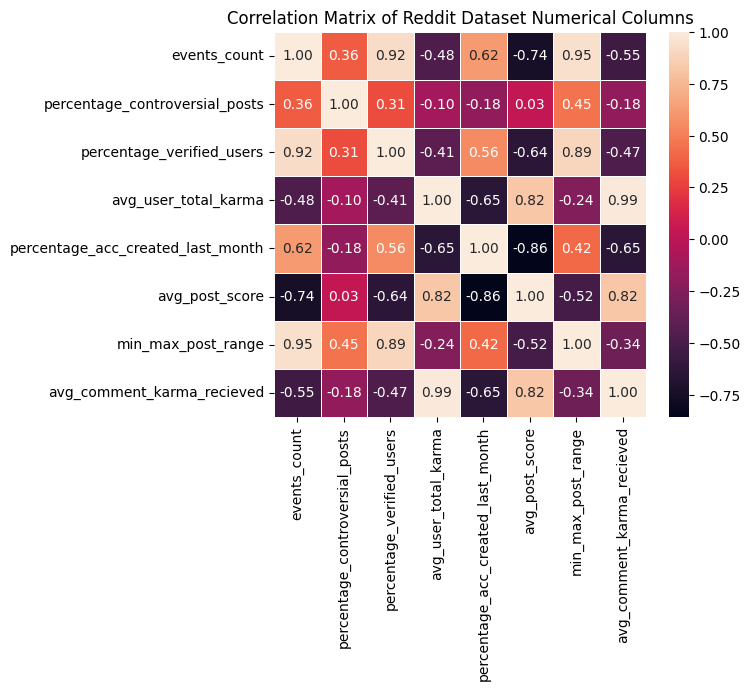

In [17]:
import seaborn as sns
import matplotlib.pyplot as plt

correlation_matrix = seven_days_avg_df.corr()

plt.figure(figsize=(6, 5))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Reddit Dataset Numerical Columns')
plt.show()

In [18]:
correlation_matrix["events_count"].sort_values()

avg_post_score                      -0.743263
avg_comment_karma_recieved          -0.551035
avg_user_total_karma                -0.478138
percentage_controversial_posts       0.364249
percentage_acc_created_last_month    0.621457
percentage_verified_users            0.924235
min_max_post_range                   0.945124
events_count                         1.000000
Name: events_count, dtype: float64

In [19]:
df_reddit.columns

Index(['comment_id', 'score', 'self_text', 'subreddit', 'created_time',
       'post_id', 'author_name', 'controversiality', 'ups', 'downs',
       'user_is_verified', 'user_account_created_time', 'user_awardee_karma',
       'user_awarder_karma', 'user_link_karma', 'user_comment_karma',
       'user_total_karma', 'post_score', 'post_self_text', 'post_title',
       'post_upvote_ratio', 'post_thumbs_ups', 'post_total_awards_received',
       'post_created_time'],
      dtype='object')

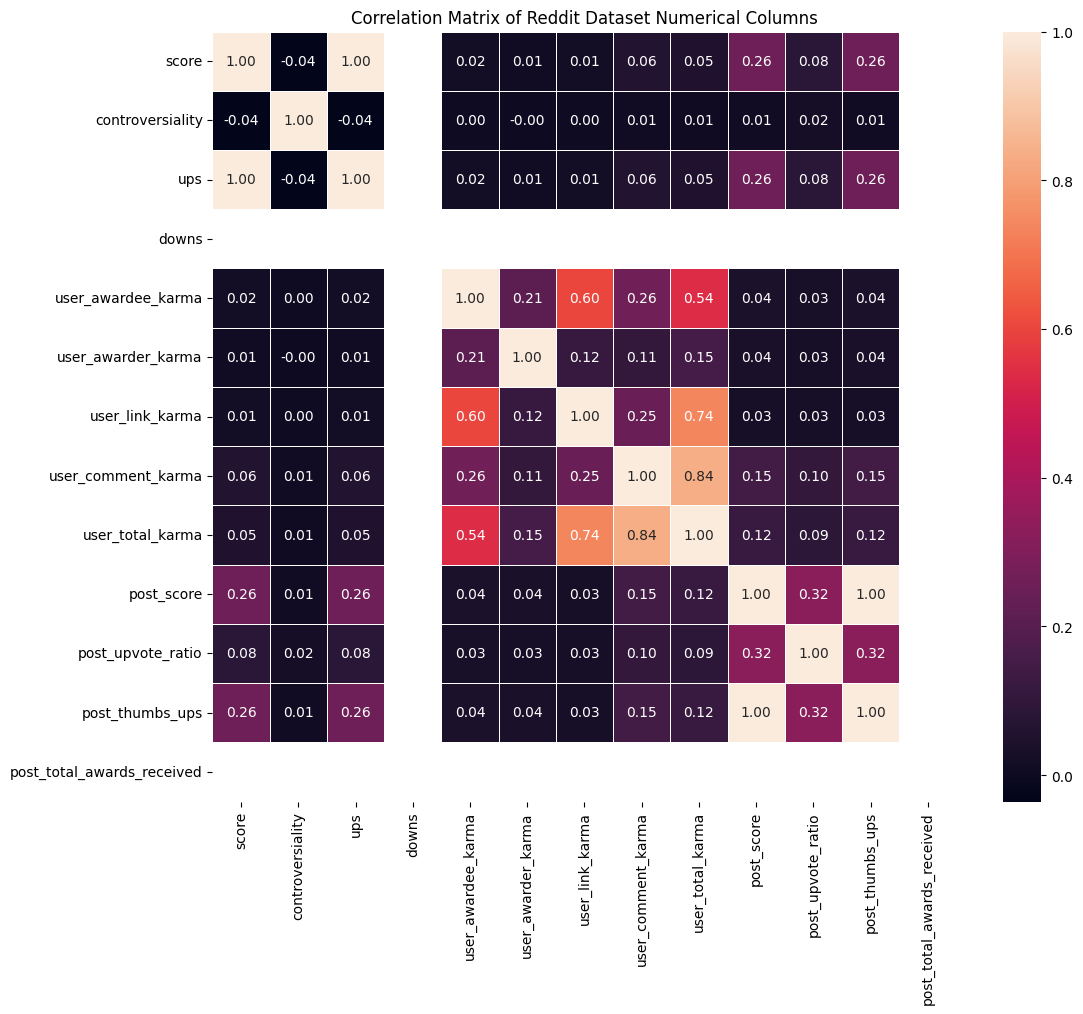

In [20]:
import seaborn as sns
import matplotlib.pyplot as plt

numerical_columns_reddit = df_reddit.select_dtypes(
    include=['int64', 'float64'])

correlation_matrix = numerical_columns_reddit.corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of Reddit Dataset Numerical Columns')
plt.show()

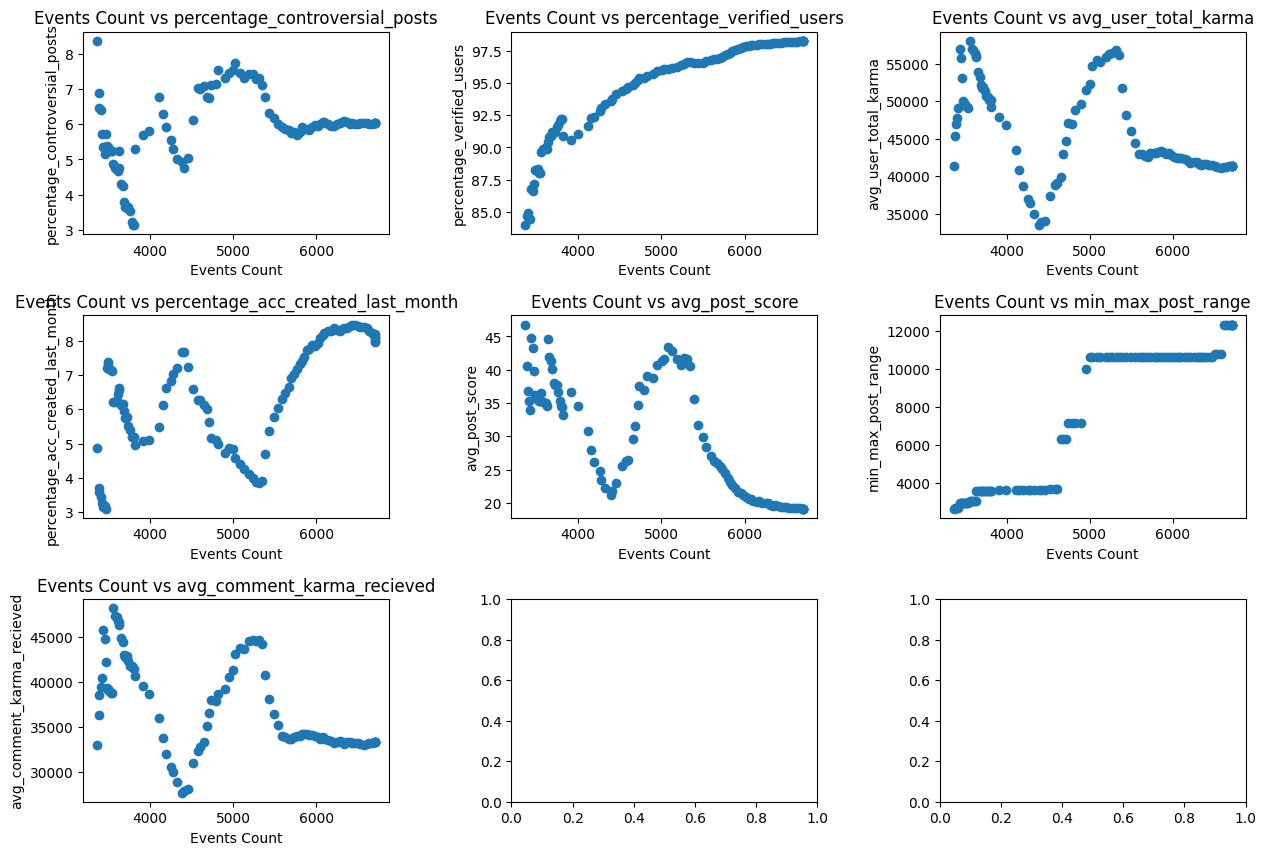

In [21]:
fig, axs = plt.subplots(nrows=3, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.4, wspace=0.4)
for i, column in enumerate(seven_days_avg_df.columns[1:]):
    ax = axs[i//3, i % 3]
    ax.scatter(seven_days_avg_df["events_count"],
               seven_days_avg_df[column])
    ax.set_title(f'Events Count vs {column}')
    ax.set_xlabel('Events Count')
    ax.set_ylabel(column)


plt.show()

## Linear Regression


In [47]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

X = seven_days_avg_df.drop('events_count', axis=1)
# [["avg_post_score", "avg_comment_karma_recieved",
#                                                   "percentage_acc_created_last_month", "percentage_verified_users", "min_max_post_range"]]

y = seven_days_avg_df['events_count']


scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y, test_size=0.2, random_state=42)

model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [48]:
y_pred = model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

"Mse: ", mse, "r^2: ", r2

('Mse: ', 29692.004216385252, 'r^2: ', 0.9800465881151482)

In [49]:
from sklearn.linear_model import ElasticNet

el_model = ElasticNet()
el_model.fit(X_train, y_train)

y_pred = el_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

"Mse: ", mse, "r^2: ", r2

('Mse: ', 92866.69416287365, 'r^2: ', 0.9375923772099622)

In [50]:
seven_days_avg_df.describe()

,events_count,percentage_controversial_posts,percentage_verified_users,avg_user_total_karma,percentage_acc_created_last_month,avg_post_score,min_max_post_range,avg_comment_karma_recieved
count,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000,105.000000
mean,4952.142857,5.860867,94.198688,46139.037814,6.414619,30.001257,7373.914286,37177.368722
std,1132.070494,1.046270,4.020494,6174.317918,1.564565,8.572430,3726.936657,5066.233998
min,3363.000000,3.133677,83.972125,33484.770508,3.095238,19.126360,2622.000000,27674.992203
25%,3755.000000,5.313496,91.179654,41515.499766,5.196351,21.197567,3543.000000,33266.568847
50%,4950.000000,5.994116,95.912777,43339.144236,6.562756,29.894170,10009.000000,35034.542284
75%,5982.000000,6.301905,97.778228,50686.941964,7.880142,36.820574,10668.000000,41453.637842
max,6709.000000,8.362369,98.256769,58010.475599,8.469478,46.773519,12356.000000,48155.133984


## Decision Trees


In [51]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

rf = RandomForestRegressor(
    n_estimators=100, random_state=42)


grid_search = GridSearchCV(RandomForestRegressor(random_state=42), {'min_samples_leaf': [2, 3, 4, 5], "n_estimators": [
                           i for i in range(1, 200, 10)]}, cv=5, scoring="neg_mean_squared_error", return_train_score=True, n_jobs=-1)

grid_search.fit(X_train, y_train)

# min_sample_split=3
# rf.fit(X_train, y_train)

grid_search.best_params_, grid_search.best_score_, grid_search.best_estimator_.feature_importances_

({'min_samples_leaf': 2, 'n_estimators': 21},
 -3942.4687787214266,
 array([0.0042452 , 0.77806549, 0.01197252, 0.03802274, 0.02319622,
        0.13766078, 0.00683706]))

In [52]:
sorted(zip(X.columns, grid_search.best_estimator_.feature_importances_),
       key=lambda x: x[1], reverse=True)

[('percentage_verified_users', 0.7780654854034974),
 ('min_max_post_range', 0.13766078043071875),
 ('percentage_acc_created_last_month', 0.03802273549226294),
 ('avg_post_score', 0.023196224028216004),
 ('avg_user_total_karma', 0.011972522428918504),
 ('avg_comment_karma_recieved', 0.006837055228769871),
 ('percentage_controversial_posts', 0.004245196987616472)]

In [53]:
y_pred = rf.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")

NotFittedError: This RandomForestRegressor instance is not fitted yet. Call 'fit' with appropriate arguments before using this estimator.